# AI Text Summarizer

### Import Requirements

In [1]:
# python3 -m venv venv
# source venv/bin/activate

In [1]:
%pip install rouge_score
%pip install evaluate
%pip install --upgrade -q wandb
%pip install --upgrade datasets
%pip install python-dotenv
# %pip install torch==2.4.1 torchvision==0.19.1 torchaudio==2.4.1 --index-url https://download.pytorch.org/whl/cpu
%pip install torch==2.4.1 torchvision==0.19.1 torchaudio==2.4.1 --index-url https://download.pytorch.org/whl/cu121
%pip install --upgrade transformers
%pip install --upgrade transformers[torch]
%pip install seaborn
%pip install torch-directml


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: /Users/bshowell/Desktop/school/winter 24-25/480/.venv/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: /Users/bshowell/Desktop/school/winter 24-25/480/.venv/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: /Users/bshowell/Desktop/school/winter 24-25/480/.venv/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
  Attempting uninstall: datasets
    Found existing installation: datasets 3.2.0
    Uninstalling datasets-3.2.0:
      Successfully uninstalled datasets-3.2.0

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: /Users/bshow

In [ ]:
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, pipeline, set_seed
from transformers import DataCollatorForSeq2Seq
from transformers import Seq2SeqTrainer
from transformers import Seq2SeqTrainingArguments
from transformers import AutoTokenizer

import datasets
from datasets import Dataset
from datasets import DatasetDict

from evaluate import load

from tqdm import tqdm

import wandb
import huggingface_hub

import nltk
from nltk.tokenize import sent_tokenize
nltk.download("punkt_tab")

import warnings
warnings.filterwarnings('ignore')

import evaluate



/Users/bshowell/Desktop/school/winter 24-25/480/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/bshowell/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [3]:
# verifying CUDA is available
print("Torch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available()) # should be true if your graphics card is captable with NVIDIA CUDA
print("CUDA Version:", torch.version.cuda)
print("Number of GPUs:", torch.cuda.device_count())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")

Torch Version: 2.6.0
CUDA Available: False
CUDA Version: None
Number of GPUs: 0
GPU Name: No GPU detected


In [4]:
# Load environment variables from .env file
load_dotenv()

# Retrieve tokens from environment variables
huggingface_token = os.getenv("HUGGINGFACE_TOKEN")
wandb_token = os.getenv("WANDB_API_KEY")

In [5]:
# log in to wandb
wandb.login(key=wandb_token)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/bshowell/.netrc
wandb: Currently logged in as: bernicelau (ai-text-summarizer) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
# initializing/creating wandb project
#os.environ["WANDB_MODE"] = "offline" # TODO: trouble connecting to wandb due to restricting network, so keeping it offline for now
wandb.init(project="ai-text_summmarizer")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [7]:
# log in to Hugging Face Hub
huggingface_hub.login(token=huggingface_token)

In [9]:
# Check if CUDA or MPS is available and set the device
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print("Device:", device)

# Model checkpoint
model_ckpt = "facebook/bart-base"

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

Device: mps


In [45]:
# Data Analysis
dataset_paths = 'bbc-news-dataset'
articles_path = 'news-articles'
summaries_path = 'summaries'

articles = []
summaries = []
file_arr = []



folders = os.listdir(dataset_paths + '/' + articles_path)

for folder in folders:
    files = os.listdir(dataset_paths + '/' + articles_path + '/' + folder)
    for file in files:
        article_file_path = os.path.join(dataset_paths, articles_path, folder, file)
        summary_file_path = os.path.join(dataset_paths, summaries_path, folder, file)

        try:
            with open (article_file_path,'r') as f:
                articles.append('.'.join([line.rstrip() for line in f.readlines()]))
            with open (summary_file_path,'r') as f:
                summaries.append('.'.join([line.rstrip() for line in f.readlines()]))
            file_arr.append(folder + '/' + file)
        except Exception as e:
            print(f"Error reading file {folder}/{file} with error `{e}`")

In [11]:
df = pd.DataFrame({'path':file_arr,'article': articles,'summary':summaries})
df.head()

,path,article,summary
0,entertainment/289.txt,Musicians to tackle US red tape..Musicians' gr...,Nigel McCune from the Musicians' Union said Br...
1,entertainment/262.txt,"U2's desire to be number one..U2, who have won...",But they still want more.They have to want to ...
2,entertainment/276.txt,Rocker Doherty in on-stage fight..Rock singer ...,"Babyshambles, which he formed after his acrimo..."
3,entertainment/060.txt,Snicket tops US box office chart..The film ada...,A Series of Unfortunate Events also stars Scot...
4,entertainment/074.txt,Ocean's Twelve raids box office..Ocean's Twelv...,"Ocean's Twelve, the crime caper sequel starrin..."


In [43]:
# removing nans if any

print("Before:\n", df.isnull().sum(), "\n", sep="")
df.dropna(inplace=True)
print("After:\n", df.isnull().sum(), sep="")

Before:
path                 0
article              0
summary              0
num_words_article    0
num_words_summary    0
dtype: int64

After:
path                 0
article              0
summary              0
num_words_article    0
num_words_summary    0
dtype: int64


In [13]:
# crating function to count the words in each sample

def word_count(sentence):
    sentences = sentence.split()
    return len(sentences)

In [14]:
# creating new columns of word numbers

df['num_words_article'] = df['article'].apply(word_count)
df['num_words_summary'] = df['summary'].apply(word_count)
df.head()

,path,article,summary,num_words_article,num_words_summary
0,entertainment/289.txt,Musicians to tackle US red tape..Musicians' gr...,Nigel McCune from the Musicians' Union said Br...,372,153
1,entertainment/262.txt,"U2's desire to be number one..U2, who have won...",But they still want more.They have to want to ...,829,376
2,entertainment/276.txt,Rocker Doherty in on-stage fight..Rock singer ...,"Babyshambles, which he formed after his acrimo...",354,142
3,entertainment/060.txt,Snicket tops US box office chart..The film ada...,A Series of Unfortunate Events also stars Scot...,174,69
4,entertainment/074.txt,Ocean's Twelve raids box office..Ocean's Twelv...,"Ocean's Twelve, the crime caper sequel starrin...",248,126


In [15]:
# getting statistical info about the word lenghths

df.describe()

,num_words_article,num_words_summary
count,2224.000000,2224.000000
mean,379.286871,165.151529
std,235.081995,108.678038
min,87.000000,38.000000
25%,242.000000,103.000000
50%,327.000000,142.000000
75%,465.250000,202.000000
max,4377.000000,2073.000000


Upper whisker: 799.0
Q3: 465.25
Q2: 327.0
Q1: 242.0
Lower whisker: 87.0


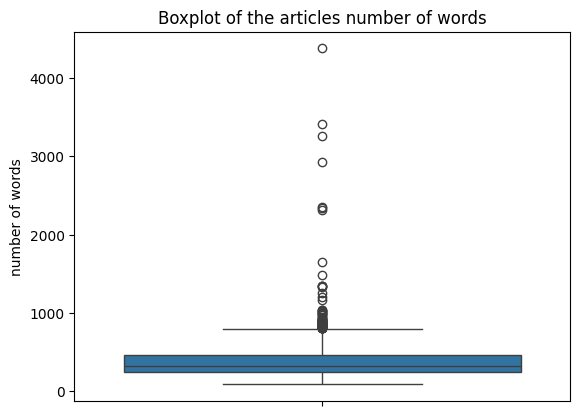

In [16]:
sns.boxplot(df["num_words_article"])
plt.ylabel("number of words")
plt.title("Boxplot of the articles number of words")

lines = plt.gca().lines[:6]
all_lines = [lines[i].get_ydata()[0] for i in range(5)]

Q1,Q3,article_lower_whisker,article_upper_whisker, Q2 = all_lines

print("Upper whisker:", article_upper_whisker)
print("Q3:", Q3)
print("Q2:", Q2)
print("Q1:", Q1)
print("Lower whisker:", article_lower_whisker)

Upper whisker: 350.0
Q3: 202.0
Q2: 142.0
Q1: 103.0
Lower whisker: 38.0


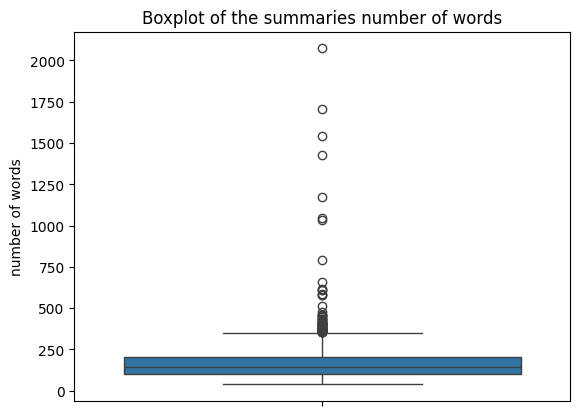

In [17]:
sns.boxplot(df["num_words_summary"])
plt.ylabel("number of words")
plt.title("Boxplot of the summaries number of words")

lines = plt.gca().lines[:6]
all_lines = [lines[i].get_ydata()[0] for i in range(5)]

Q1,Q3,summary_lower_whisker,summary_upper_whisker, Q2 = all_lines

print("Upper whisker:", summary_upper_whisker)
print("Q3:", Q3)
print("Q2:", Q2)
print("Q1:", Q1)
print("Lower whisker:", summary_lower_whisker)

In [39]:
# removing the samples of very long sequences

new_df = df[(df['num_words_summary'] <= summary_upper_whisker) & (df['num_words_article'] <= article_upper_whisker)]
new_df

,path,article,summary,num_words_article,num_words_summary
0,entertainment/289.txt,Musicians to tackle US red tape..Musicians' gr...,Nigel McCune from the Musicians' Union said Br...,372,153
2,entertainment/276.txt,Rocker Doherty in on-stage fight..Rock singer ...,"Babyshambles, which he formed after his acrimo...",354,142
3,entertainment/060.txt,Snicket tops US box office chart..The film ada...,A Series of Unfortunate Events also stars Scot...,174,69
4,entertainment/074.txt,Ocean's Twelve raids box office..Ocean's Twelv...,"Ocean's Twelve, the crime caper sequel starrin...",248,126
5,entertainment/048.txt,'Landmark movies' of 2004 hailed..US film prof...,The Institute also cited the death of actor Ma...,328,127
...,...,...,...,...,...
2219,tech/086.txt,Warning over Windows Word files..Writing a Mic...,Writing a Microsoft Word document can be a dan...,456,182
2220,tech/253.txt,Fast lifts rise into record books..Two high-sp...,The lifts take only 30 seconds to whisk passen...,379,205
2221,tech/247.txt,Nintendo adds media playing to DS..Nintendo is...,Nintendo is releasing an adapter for its DS ha...,289,102
2222,tech/290.txt,Fast moving phone viruses appear..Security fir...,The new strains of the Cabir mobile phone viru...,327,138


In [40]:
# preparing the data by training 0.03% of the dataset

# deleting some columns and shuffling the rows

# TODO - not sure if this is working with the drop as expected

new_df.drop(columns=["num_words_article","num_words_summary","path"])
new_df = new_df.sample(frac = 0.03)
new_df.reset_index(drop=True, inplace=False)

,path,article,summary,num_words_article,num_words_summary
0,business/158.txt,Qatar and Shell in $6bn gas deal..Shell has si...,ExxonMobil will be taking some 15 million tonn...,158,53
1,sport/494.txt,Roche 'turns down Federer offer'..Australian t...,Australian tennis coach Tony Roche has turned ...,181,83
2,tech/293.txt,File-swappers ready new network..Legal attacks...,Sloncek said that currently only a Windows ver...,665,290
3,politics/211.txt,Top judge clashes with ministers..The UK's top...,"""As Lord Woolf also acknowledged, it is highly...",523,219
4,sport/394.txt,Tindall wants second opinion..England centre M...,England centre Mike Tindall is to seek a secon...,185,88
...,...,...,...,...,...
59,business/052.txt,Italy to get economic action plan..Italian Pri...,The government says that it has set about tack...,478,211
60,politics/084.txt,Job cuts 'false economy' - TUC..Plans to shed...,"Plans to shed 71,000 civil service jobs will p...",255,106
61,business/431.txt,Mitsubishi in Peugeot link talks..Trouble-hit ...,Trouble-hit Mitsubishi Motors is in talks with...,160,69
62,business/165.txt,Consumer spending lifts US growth..US economic...,US economic growth accelerated in the third qu...,359,148


In [20]:
# splitting the data into train and test

ratio = 0.8
split = int(len(new_df)*ratio)

train_df = new_df.iloc[:split]
test_df = new_df.iloc[split:]

In [21]:
# convert the DataFrame into DatasetDict

train_dataset = Dataset.from_dict(train_df)
test_dataset = Dataset.from_dict(test_df)
dataset = datasets.DatasetDict({"train":train_dataset,"test":test_dataset})
dataset

DatasetDict({
    train: Dataset({
        features: ['path', 'article', 'summary', 'num_words_article', 'num_words_summary'],
        num_rows: 51
    })
    test: Dataset({
        features: ['path', 'article', 'summary', 'num_words_article', 'num_words_summary'],
        num_rows: 13
    })
})

In [22]:
max_input_length = int(article_upper_whisker)
max_target_length = int(summary_upper_whisker)

def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["article"],
        max_length=max_input_length,
        truncation=True,
    )
    labels = tokenizer(
        examples["summary"], max_length=max_target_length, truncation=True
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [23]:
# initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# define max input lengths
max_input_length = int(article_upper_whisker)
max_target_length = int(summary_upper_whisker)

tokenized_datasets = dataset.map(preprocess_function, batched=True)

Map: 100%|██████████| 13/13 [00:00<00:00, 1607.11 examples/s]


In [24]:
# ROUGE metric for automatic summarization and machine translation software in Natural Language Processing

rouge_score = evaluate.load("rouge")

In [25]:
# example on using rouge

generated_summary = "I absolutely loved reading the Hunger Games"
reference_summary = "I loved reading the Hunger Games"
scores = rouge_score.compute(predictions=[generated_summary], references=[reference_summary])
scores

{'rouge1': np.float64(0.923076923076923),
 'rouge2': np.float64(0.7272727272727272),
 'rougeL': np.float64(0.923076923076923),
 'rougeLsum': np.float64(0.923076923076923)}

In [26]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    # Decode generated summaries into text
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    # Replace -100 in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    # Decode reference summaries into text
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # ROUGE expects a newline after each sentence
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]

    # Compute ROUGE scores
    result = rouge_score.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    return {k: round(v, 4) for k, v in result.items()}

In [ ]:
# generate summaries
summarizer = pipeline("summarization", model=model_ckpt)

def print_summary(idx):
    article = dataset["test"][idx]["article"]
    summary = dataset["test"][idx]["summary"]
    g_summary = summarizer(dataset["test"][idx]["article"])[0]["summary_text"]
    score = rouge_score.compute(predictions=[g_summary], references=[summary])
    scores = {k: round(v, 4) for k, v in score.items()}
    print(f"'>>> Article: {article}'")
    print(f"\n'>>> Summary: {summary}'")
    print(f"\n'>>> Generated Summary: {g_summary}'")
    print(f"\n'>>> ROUGE Score: {scores}'")


print_summary(5)

Device set to use mps:0


'>>> Article: Ukraine revisits state sell-offs..Ukraine is preparing what could be a wholesale review of the privatisation of thousands of businesses by the previous administration...The new President, Viktor Yushchenko, has said a "limited" list of companies is being drawn up. But on Wednesday Prime Minister Yulia Tymoshenko said the government was planning to renationalise 3,000 firms. The government says many privatised firms were sold to allies of the last administration at rock-bottom prices. More than 90,000 businesses in all, from massive corporations to tiny shopfronts, have been sold off since 1992, as the command economy built up when Ukraine was part of the Soviet Union was dismantled...Ms Tymoshenko said prosecutors had drawn up a list of more than 3,000 businesses which were to be reviewed. "We will return to the state that which was illegally put into private hands."..A day earlier, Mr Yushchenko - keen to reassure potential investors - had said only 30 to 40 top firms wo

In [28]:
# fine tuning BART model

# creating data_collator
# A data_collator is a function that takes a batch of data and collates it into a format suitable for model training

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [29]:
# removing the columns with strings because the collator won’t know how to pad these elements

tokenized_datasets = tokenized_datasets.remove_columns(dataset["train"].column_names)

In [ ]:
batch_size = 8
num_train_epochs = 8
# Show the training loss with every epoch
logging_steps = len(tokenized_datasets["train"]) // batch_size
model_name = model_ckpt


args = Seq2SeqTrainingArguments(
    output_dir=f"{model_name}-finetuned-BBC",
    evaluation_strategy="epoch",
    learning_rate=5.6e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=num_train_epochs,
    predict_with_generate=True,
    logging_steps=logging_steps,
    push_to_hub=True,
    run_name="text_summmarizer",
    report_to="wandb", # ensures WandB logging is enabled
    hub_token=huggingface_token,
    )

In [31]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,)

In [32]:
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,1.373600,0.356015,0.142700,0.086900,0.119700,0.122300
2,0.503600,0.270375,0.198200,0.182400,0.199500,0.198100
3,0.374300,0.264061,0.184400,0.164700,0.184200,0.184000
4,0.393500,0.240321,0.177100,0.153400,0.177300,0.177300
5,0.307000,0.231639,0.181100,0.157700,0.181500,0.181500
6,0.238700,0.223142,0.169800,0.142600,0.170800,0.170000
7,0.240800,0.221663,0.167800,0.140700,0.168200,0.167800
8,0.208600,0.223280,0.167800,0.140700,0.168200,0.167800


TrainOutput(global_step=56, training_loss=0.42725147732666563, metrics={'train_runtime': 185.4535, 'train_samples_per_second': 2.2, 'train_steps_per_second': 0.302, 'total_flos': 175416534558720.0, 'train_loss': 0.42725147732666563, 'epoch': 8.0})

In [36]:
input_text = """
The Amazon rainforest is often referred to as the "lungs of the Earth" because of its critical role in producing oxygen and absorbing carbon dioxide. It spans across several countries in South America, including Brazil, Peru, and Colombia, and is home to an incredibly diverse array of wildlife, plants, and indigenous cultures. Unfortunately, the Amazon is facing significant threats due to deforestation, illegal logging, mining, and agricultural expansion. These activities are rapidly destroying large portions of the rainforest, which not only contributes to the loss of biodiversity but also accelerates climate change by releasing stored carbon into the atmosphere.

In recent years, global efforts to protect the Amazon have intensified, with governments, NGOs, and international organizations working together to implement conservation strategies and policies. One such initiative is the creation of protected areas and indigenous territories that restrict harmful activities. However, enforcement of these measures remains a challenge, particularly in remote regions where illegal activities are rampant.

Another important issue is the role of indigenous peoples in protecting the forest. Many indigenous communities have lived in the Amazon for centuries and possess a deep understanding of the ecosystem. These communities are often the first line of defense against environmental destruction and have been leading efforts to preserve their land and culture. Yet, they face increasing threats from outside forces seeking to exploit the land for economic gain.

Climate change is exacerbating the situation, with rising temperatures and altered rainfall patterns putting additional pressure on the Amazon. Scientists have warned that if current trends continue, the rainforest could reach a tipping point where it can no longer function as a carbon sink, further accelerating global warming. Given its global significance, the fate of the Amazon is a pressing issue that requires urgent and coordinated action on a global scale.
"""

# Tokenize input text
inputs = tokenizer(input_text, return_tensors="pt", max_length=2048, truncation=True).to(device)

# Generate summary
summary_ids = model.generate(
    inputs['input_ids'],
    num_beams=8,
    max_length=200,
    min_length=100,
    early_stopping=True,
    temperature=0.8
)

# Decode the summary
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Post-process to format the summary in bullet points
# Split the summary into sentences by splitting on '.'
sentences = summary.split(".")

# Remove any extra spaces, empty sentences, or non-english characters
sentences = ["\n- " + sentence.strip() + "." for sentence in sentences if sentence.encode('ascii', errors='ignore').decode().strip()]

# Join sentences with bullet points
# formatted_summary = "".join(sentences)
formatted_summary = ""
for sen in sentences:
    formatted_summary = formatted_summary + sen

# Print the formatted summary
print("Summary in Bullet Points:", formatted_summary)

Summary in Bullet Points: 
- The Amazon rainforest is often referred to as the "lungs of the Earth" because of its critical role in producing oxygen and absorbing carbon dioxide.
- It spans across several countries in South America, including Brazil, Peru, and Colombia, and is home to an incredibly diverse array of wildlife, plants, and indigenous cultures.
- Unfortunately, the Amazon is facing significant threats due to deforestation, illegal logging, mining, and agricultural expansion.
- These activities are rapidly destroying large portions of the rainforest, which not only contributes to the loss of biodiversity but also accelerates climate change by releasing stored carbon into the atmosphere.
